## Imports

In [1]:
import joblib
import time
import numpy as np
import pandas as pd, os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV

## Preprocessing & Data Split

Split the 'valid_time' into date and time

In [2]:
def extract_datetime_features(df):
    df['valid_time'] = pd.to_datetime(df['valid_time']) # Transfer 'valid_time' into datetime type
    df['year'] = df['valid_time'].dt.year
    df['month'] = df['valid_time'].dt.month
    df['day'] = df['valid_time'].dt.day
    df['hour'] = df['valid_time'].dt.hour
    df["season"] = ((df["month"] % 12 + 3) // 3) + 1
    return df.drop(["id"], axis=1)

Add nearby features to strength the dataset, allowing the model to capture the continuity and spatial connection of the weather.

In [3]:
# Add historical data for the specific place, time lag is one hour. Places without last hour's data results in N/A so will need to drop N/A after applying this.
def add_lag_features(df, features, group_cols=['latitude', 'longitude'], lag=1):
    df = df.sort_values(by=group_cols + ['valid_time']).reset_index(drop=True)
    for feat in features:
        df[f'{feat}_lag{lag}'] = df.groupby(group_cols)[feat].shift(lag)
        df[f'{feat}_lag{lag}'] = df[f'{feat}_lag{lag}'].fillna(df[feat])

    return df

# Construct a 3*3 window for each spot to compute the average data for the nine neighbors.
def add_spatial_averages(df, features, lat_step=0.25, lon_step=0.25):
    avg_features = []
    for feat in features:
        df_list = []
        for dlat in [-lat_step, 0, lat_step]:
            for dlon in [-lon_step, 0, lon_step]:
                shifted = df[['latitude', 'longitude', 'valid_time', feat]].copy()
                shifted['latitude'] += dlat
                shifted['longitude'] += dlon
                shifted = shifted.rename(columns={feat: f'{feat}_shift_{dlat}_{dlon}'})
                df_list.append(shifted)
        for df_part in df_list:
            df = df.merge(df_part, on=['latitude', 'longitude', 'valid_time'], how='left')
        mean_cols = [f'{feat}_shift_{dlat}_{dlon}' for dlat in [-lat_step, 0, lat_step] for dlon in [-lon_step, 0, lon_step]]
        df[f'{feat}_spatial_mean'] = df[mean_cols].mean(axis=1)
        df = df.drop(columns=mean_cols)
        # Fill missing spatial means with original feature value
        df[f'{feat}_spatial_mean'] = df[f'{feat}_spatial_mean'].fillna(df[feat])
        avg_features.append(f'{feat}_spatial_mean')
    return df

Prepare datasets

In [4]:
standard_features = [
    'tp', 'sp', 'u10', 'v10', 'u100', 'v100', 'tcc', 'ptype',
    'month', 'day', 'hour', 'season'
]

lag_vars = ['tp', 'sp', 'u10', 'v10']
spatial_vars = ['tp', 'sp', 'tcc']

# For consistency, define lag and spatial lag features
lag_features = [f'{var}_lag1' for var in lag_vars]
spatial_lag_features = [f'{var}_lag1_spatial_mean' for var in lag_vars]

final_features = standard_features + lag_features + spatial_vars + spatial_lag_features

# Load dataset and, split valid_time, sampling for model training.
def prepare_dataset(option='standard', path='data/train.csv'):

    df = pd.read_csv(path).copy()
    df = extract_datetime_features(df)
    df = df.sort_values(by=['latitude', 'longitude', 'valid_time']).reset_index(drop=True)

    if option == 'standard':
        df = df[standard_features + ['t2m']].dropna()
        return df
    if option == 'with_lag':
        df = add_lag_features(df, lag_vars)
        df = df[standard_features + lag_features + ['t2m']].dropna()
        return df
    if option == 'with_lag_spatial':
        df = add_lag_features(df, lag_vars)
        df = add_spatial_averages(df, spatial_vars)
        df = add_spatial_averages(df, lag_features)
        df = df[final_features + ['t2m']].dropna()
        return df
    raise ValueError("Invalid option. Choose from 'standard', 'with_lag', 'with_lag_spatial'")

## Split sampled train dataset

In [5]:
# 1. Load strengthened data and sampling.
df = prepare_dataset('with_lag_spatial')

# Check if the processed dataset already exists.
if os.path.exists("df.csv"):
    df = pd.read_csv("df.csv")
    print("Loaded: df.csv")
else:
    df.to_csv("df.csv", index=False)
    print("Saved: df.csv")

# Sampling for the fine-tuning
df_sample = df.sample(frac=0.1, random_state=42)

# 2. Split train and validation set on the sample
X_sample = df_sample.drop(columns=['t2m'])
y_sample = df_sample['t2m']
X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)


Loaded: df.csv


## Fine tuning

In [6]:
# Fallback Strategy, in case there's already a model
if os.path.exists("rf_best_model.pkl"):
    rf_best_model = joblib.load("rf_best_model.pkl")
    print("Loaded existing tuned model: rf_best_model.pkl")
else:
    start = time.perf_counter()
    # Parameters
    param_dist = {
        'n_estimators': [100, 200, 300],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_depth': [20, 30, 40],
        'max_features': ['sqrt', 'log2'],
    }
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    # Settings
    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=1,
        cv=3,
        scoring='neg_mean_squared_error',
        verbose=1,
        random_state=42,
        n_jobs=-1,
        error_score='raise'
    )

    # Fit the model
    search.fit(X_train, y_train)
    end = time.perf_counter()
    print(f"Tuning time: {end - start:.2f} seconds")

    # Find the best model
    rf_best_model = search.best_estimator_
    joblib.dump(rf_best_model, "rf_best_model.pkl", compress=3)
    print("Best sample model saved to rf_best_model.pkl")

Loaded existing tuned model: rf_best_model.pkl


### Evaluation on the validation set

In [7]:
# Evaluation by three indexes
y_val_pred = rf_best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
print(f"Validation RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")
print("Best Parameters:", search.best_params_)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- sp.1
- tcc.1
- tp.1


## Final Model trained on the whole dataset

In [ ]:
# 1. Features and target value
X = df.drop(columns=['t2m'])
y = df['t2m']
X_full, X_val_full, y_full, y_val_full = train_test_split(X, y, test_size=0.2, random_state=42)
X_full.to_csv("full_train_data.csv", index=False)

# Save copy of split train and validation sets
X_full.to_csv("X_full.csv", index=False)
X_val_full.to_csv("X_val_full.csv", index=False)
y_full.to_csv("y_full.csv", index=False)
y_val_full.to_csv("y_val_full.csv", index=False)
print("Saved: training and validation splits on full dataset")

# Fallback
if os.path.exists("rf_final_model.pkl"):
    final_model = joblib.load("rf_final_model.pkl")
    print("Loaded final model from rf_final_model.pkl")
else:
    # 2. Construct final model（using search.best_params）
    start = time.perf_counter()
    params = rf_best_model.get_params()
    params["n_jobs"] = -1
    params["random_state"] = 42

    # 3. Construct new model on the parameters
    final_model = RandomForestRegressor(**params)

    final_model.fit(X_full, y_full)
    end = time.perf_counter()
    print(f"Final model training time: {end - start:.2f} seconds")
    joblib.dump(final_model, 'rf_final_model.pkl', compress=3)
    print("Final model trained on full dataset and saved as 'rf_final_model.pkl'")

Saved: training and validation splits on full dataset
Final model training time: 722.77 seconds
Final model trained on full dataset and saved as 'rf_final_model.pkl'


## Evaluation
The model is evaluated by three scores: RMSE, R2, and MAE.

In [ ]:
# Evaluation metrics
y_pred = final_model.predict(X_full)
y_val_pred = final_model.predict(X_val_full)

train_rmse = np.sqrt(mean_squared_error(y_full, y_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_full, y_val_pred))
train_r2 = r2_score(y_full, y_pred)
val_r2 = r2_score(y_val_full, y_val_pred)
train_mae = mean_absolute_error(y_full, y_pred)
val_mae = mean_absolute_error(y_val_full, y_val_pred)

print("Evaluations on Full Dataset")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

Evaluations on Full Dataset
Training RMSE: 0.6094
Validation RMSE: 0.8288
Training R²: 0.9845
Validation R²: 0.9714
Training MAE: 0.3806
Validation MAE: 0.5354


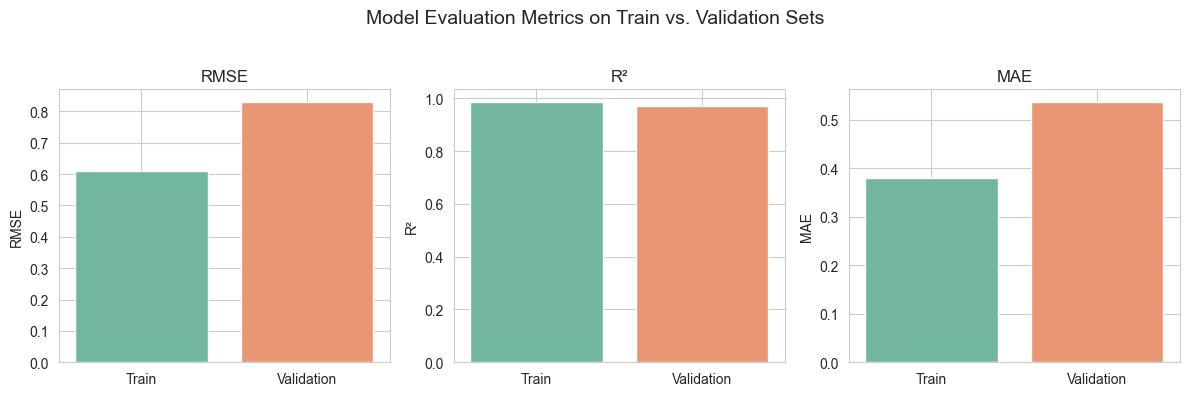

In [ ]:
# Visualisation of evaluations
# Create evaluation DataFrame
metrics_df = pd.DataFrame({
    'RMSE': [train_rmse, val_rmse],
    'R²': [train_r2, val_r2],
    'MAE': [train_mae, val_mae]
}, index=['Train', 'Validation'])

# Visualisation of all the evaluations
plt.figure(figsize=(12, 4))
for i, metric in enumerate(metrics_df.columns):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=metrics_df.index, y=metrics_df[metric], hue=metrics_df.index, palette='Set2')
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel("")
    plt.grid(True)

plt.suptitle("Model Evaluation Metrics on Train vs. Validation Sets", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Predictions on the full dataset

### Saving the validation predictions
This will be later used in the final Evaluation file

In [ ]:
if os.path.exists("rf_y_valid_predictions.csv"):
    print("Validation predictions file already exists. Skipping prediction.")
else:
    # Predict on the full validation dataset
    print("Start Predicting……")

    # Save predictions and true values on full validation set
    df_val_results = pd.DataFrame({
        'true_t2m': y_val_full.values,
        'predicted_t2m': y_val_pred
    })
    print("Predicting done！")

    df_val_results.to_csv('rf_y_valid_predictions.csv', index=False)
    print("Full validation results saved to 'rf_y_valid_predictions.csv'")

Start Predicting……
Predicting done！
Full validation results saved to 'rf_y_valid_predictions.csv'


### Save strengthened test set for the required final predictions

In [ ]:

if os.path.exists("processed_test_with_nearby_features.csv"):
    test_df = pd.read_csv("processed_test_with_nearby_features.csv")
    print("Loaded processed test set with nearby features")
else:
    # Print out the time this cell uses
    start = time.perf_counter()

    # Read and process test set
    test_df = pd.read_csv('data/test.csv').copy()
    test_df = extract_datetime_features(test_df)
    test_df = test_df.sort_values(by=['latitude', 'longitude', 'valid_time']).reset_index(drop=True)

    # Add nearby features
    test_df = add_lag_features(test_df, lag_vars)
    test_df = add_spatial_averages(test_df, spatial_vars)
    test_df = add_spatial_averages(test_df, lag_features)
    test_df = test_df[final_features].dropna()
    X_test = test_df[final_features]
    # Save to csv
    test_df.to_csv('processed_test_with_nearby_features.csv', index=False)
    end = time.perf_counter()
    print(f"Time to process test set: {end - start:.2f} seconds")
    print("Saved processed test set with nearby features to 'processed_test_with_nearby_features.csv'")

Time to process test set: 302.71 seconds
Saved processed test set with nearby features to 'processed_test_with_nearby_features.csv'


## Result Visualisation

### Actual vs Predicted

In [ ]:
plt.figure(figsize=(6, 6))

# Plot training and validation in different colors
sns.scatterplot(x=y_full, y=y_pred, label='Training data', alpha=0.3, color='blue')
sns.scatterplot(x=y_val_full, y=y_val_pred, label='Validation data', alpha=0.3, color='red')

# Perfect prediction line
plt.plot([y_val_full.min(), y_val_full.max()], [y_val_full.min(), y_val_full.max()], 'k--', label='Perfect prediction')

plt.xlabel('True t2m')
plt.ylabel('Predicted t2m')
plt.title('Prediction vs True Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'y_full' is not defined

<Figure size 600x600 with 0 Axes>

### Residual Analysis (Validation set)

In [ ]:
# Residual = true - predict
residuals = y_val_full - y_val_pred

# 1. Residual distribution
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30, color='salmon')
plt.title("Residual Distribution (Validation Set)")
plt.xlabel("Residual")
plt.grid(True)
plt.show()

# 2. Residual vs Prediction
plt.figure(figsize=(6, 4))
plt.scatter(y_val_pred, residuals, alpha=0.3)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted T2M")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

# 3. QQ plot（Normality test）
import scipy.stats as stats
plt.figure(figsize=(5, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.show()


### Feature Importances

In [ ]:
# Analyse which features are important, showing top 15
importances = pd.Series(final_model.feature_importances_, index=X_full.columns)
top_features = importances.sort_values(ascending=True).tail(15)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, color='skyblue')
plt.title("Top 15 Important Features (Lag Dataset)", fontsize=14)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Improvement by nearby features
This part we will compare the model performances between original dataset and strengthened dataset to understand the improvement brought by the nearby features.

### Standard dataset: training and prediction


In [ ]:
# load standard dataset
df_std = prepare_dataset(option="standard")

# split into train and validation set
X_std = df_std.drop(columns=["t2m"])
y_std = df_std["t2m"]
X_train_std, X_val_std, y_train_std, y_val_std = train_test_split(X_std, y_std, test_size=0.2, random_state=42)

# model training
rf_std = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_std.fit(X_train_std, y_train_std)

# prediction
y_pred_std = rf_std.predict(X_val_std)

# save prediction result
pd.DataFrame({
    "y_true": y_val_std,
    "y_pred": y_pred_std
}).to_csv("y_val_pred_std.csv", index=False)

print("Standard model has been trained and saved as y_val_pred_std.csv")


### Analysis and visualisation

In [ ]:
# load two sets
std_df = pd.read_csv("y_val_pred_std.csv")
lag_df = pd.read_csv("rf_y_valid_predictions.csv")

# metrics computing
metrics = {
    "RMSE": lambda y, yhat: mean_squared_error(y, yhat, squared=False),
    "R²": r2_score,
    "MAE": mean_absolute_error
}

# create comparing chart
eval_df = pd.DataFrame({
    metric: [
        func(std_df["y_true"], std_df["y_pred"]),
        func(lag_df["y_true"], lag_df["y_pred"])
    ]
    for metric, func in metrics.items()
}, index=["Standard", "Lag+Nearby"])

# visualisations
plt.figure(figsize=(12, 4))
for i, metric in enumerate(eval_df.columns):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=eval_df.index, y=eval_df[metric], palette="Set2")
    plt.title(metric)
    plt.grid(True)
    plt.ylabel(metric)

plt.suptitle("📊 Evaluation Comparison: Standard vs Lag+Nearby Features", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
